Распаковка данных по цифрам

In [1]:
! git clone --single-branch --branch  digits_and_marks_recognition_2 https://github.com/emsch/femida.git

Cloning into 'femida'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1059 (delta 1), reused 1 (delta 1), pack-reused 1055
Receiving objects: 100% (1059/1059), 111.34 MiB | 32.35 MiB/s, done.
Resolving deltas: 100% (610/610), done.


Для Запуска в Google-Colab

In [2]:
import os
os.chdir("/content/femida/research/digits_and_crosses_recognition")
os.getcwd()

'/content/femida/research/digits_and_crosses_recognition'

In [3]:
!wget https://github.com/emsch/femida/raw/digits_and_marks_recognition_2/research/digits_and_crosses_recognition/zero_and_marks.tar.gz
!wget https://github.com/emsch/femida/raw/digits_and_marks_recognition_2/research/digits_and_crosses_recognition/our_sample_digits.tar.gz

--2020-05-17 12:22:38--  https://github.com/emsch/femida/raw/digits_and_marks_recognition_2/research/digits_and_crosses_recognition/zero_and_marks.tar.gz
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/emsch/femida/digits_and_marks_recognition_2/research/digits_and_crosses_recognition/zero_and_marks.tar.gz [following]
--2020-05-17 12:22:38--  https://raw.githubusercontent.com/emsch/femida/digits_and_marks_recognition_2/research/digits_and_crosses_recognition/zero_and_marks.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60500621 (58M) [application/octet-stream]
Saving to: ‘zero_and_marks.tar.g

In [4]:
!tar -xzvf zero_and_marks.tar.gz.1
!tar -xzvf our_sample_digits.tar.gz.1

Streaming output truncated to the last 5000 lines.
zero_and_marks/zero_boxes/test/._4766.jpg
zero_and_marks/zero_boxes/test/4766.jpg
zero_and_marks/zero_boxes/test/._16221.jpg
zero_and_marks/zero_boxes/test/16221.jpg
zero_and_marks/zero_boxes/test/._21499.jpg
zero_and_marks/zero_boxes/test/21499.jpg
zero_and_marks/zero_boxes/test/._19660.jpg
zero_and_marks/zero_boxes/test/19660.jpg
zero_and_marks/zero_boxes/test/._23701.jpg
zero_and_marks/zero_boxes/test/23701.jpg
zero_and_marks/zero_boxes/test/._3592.jpg
zero_and_marks/zero_boxes/test/3592.jpg
zero_and_marks/zero_boxes/test/._28654.jpg
zero_and_marks/zero_boxes/test/28654.jpg
zero_and_marks/zero_boxes/test/._605.jpg
zero_and_marks/zero_boxes/test/605.jpg
zero_and_marks/zero_boxes/test/._5861.jpg
zero_and_marks/zero_boxes/test/5861.jpg
zero_and_marks/zero_boxes/test/._23729.jpg
zero_and_marks/zero_boxes/test/23729.jpg
zero_and_marks/zero_boxes/test/._29204.jpg
zero_and_marks/zero_boxes/test/29204.jpg
zero_and_marks/zero_boxes/test/._58

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout, BatchNormalization

import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import skimage
import cv2

from scipy import ndimage, misc

import os
import imgaug.augmenters as iaa
import imgaug as ia
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Раздел про наполнение датасета цифрами

Тут надо сконвертить в черные цифры на белом фоне

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = 255 - X_train
X_test = 255 - X_test

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq_not_7_1 = iaa.Sequential([
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
     iaa.OneOf([iaa.CropAndPad(
            percent=(-0.25, 0.25),
            pad_mode=["constant", "edge"],
            pad_cval=(0, 128)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0),
            pad_mode=["constant"],
            pad_cval=(0)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0),
            pad_mode=["constant"],
            pad_cval=(255)
    )
               ]),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.3), "y": (0.8, 1.3)}, 
            rotate=(-30, 30), 
        )),
    sometimes((iaa.SaltAndPepper(0.1))),
    
], random_order=True)


seq_7_1 = iaa.Sequential([
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
     iaa.OneOf([iaa.CropAndPad(
            percent=(-0.25, 0.25),
            pad_mode=["constant", "edge"],
            pad_cval=(0, 128)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0),
            pad_mode=["constant"],
            pad_cval=(0)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0),
            pad_mode=["constant"],
            pad_cval=(255)
    )
               ]),
    sometimes(iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, 
            rotate=(-2, 2), 
        )),
    sometimes((iaa.SaltAndPepper(0.1))),
    
], random_order=True)


seq_boxes = iaa.Sequential([
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
     iaa.OneOf([iaa.CropAndPad(
            percent=(-0.3, 0.3),
            pad_mode=["constant", "edge"],
            pad_cval=(0, 128)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0.25),
            pad_mode=["constant"],
            pad_cval=(0)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0.1),
            pad_mode=["constant"],
            pad_cval=(255)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0.1),
            pad_mode=["constant"],
            pad_cval=(100)
    )
               ]),
    sometimes(iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, 
            rotate=(-10, 10), 
        )),
    sometimes((iaa.SaltAndPepper(0.1))),
    
], random_order=True)




`our_sample_digits` – папка, в ней сложены наши семплы картинок, которые у нас получились из вырезок настоящих бланков

In [0]:
digits_to_add = dict()

for filename in os.listdir("our_sample_digits"):
    if (".png" in filename) and not filename.startswith('.'):
        filepath = "our_sample_digits/{}".format(filename)
        im=Image.open(filepath)
        im=im.resize((28 ,28),Image.ANTIALIAS)
        im = np.array(im)
        if im.shape != (28, 28):
            im = np.mean(im, axis=2)

        digit = filename[0]
        current_digits = digits_to_add.get(digit, [])
        current_digits.append(im)
        digits_to_add[digit] = current_digits
        

В дополнение к 60 тысячам MNIST добавим 30 тысяч отсемплированных наших примеров



In [0]:
X_train_self_created = []
y_train_self_created = []


sample_size = int(30000 / 10)
for i in range(10):
    y_s = sample_size * [i]
    x_s = digits_to_add[str(i)]
    x_s = np.array(x_s)
    row_i = np.random.choice(x_s.shape[0],size=sample_size)
    x_s = x_s[row_i]
    x_s = list(x_s)
    #x_s = np.random.choice(, sample_size)
    X_train_self_created += x_s
    y_train_self_created += y_s


In [0]:
X_test_self_created = []
y_test_self_created = []


sample_size = int(10000/10)
for i in range(10):
    y_s = sample_size * [i]
    x_s = digits_to_add[str(i)]
    x_s = np.array(x_s)
    row_i = np.random.choice(x_s.shape[0],size=sample_size)
    x_s = x_s[row_i]
    x_s = list(x_s)
    #x_s = np.random.choice(, sample_size)
    X_test_self_created += x_s
    y_test_self_created += y_s


Очищение отсканированных "настоящих" картинок: увеличение контрастности, уменьшение шума 

In [0]:
def pretty_scanned_digit(image_array):

    im = Image.fromarray(image_array.astype(np.uint8))
    im_from_array = im.resize((28 ,28),Image.ANTIALIAS)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    return gray_image_for_prediction

In [0]:
X_train_self_created = list(map(pretty_scanned_digit, X_train_self_created))

X_test_self_created = list(map(pretty_scanned_digit, X_test_self_created))



In [0]:
X_train = np.concatenate([X_train, X_train_self_created])
X_test = np.concatenate([X_test, X_test_self_created])

y_train = np.concatenate([y_train, y_train_self_created])
y_test = np.concatenate([y_test, y_test_self_created])

In [15]:
X_train.shape

(90000, 28, 28)

In [16]:
X_test.shape

(20000, 28, 28)

In [0]:
necessary_train_size = 1000000

In [0]:
train_choice = np.random.choice(X_train.shape[0],size=necessary_train_size)

In [0]:
X_train_choosen = X_train[train_choice]
y_train_choosen = y_train[train_choice]

In [0]:
mask_1_7 = np.isin(y_train_choosen, [1, 7])
mask_not_1_7 = ~np.isin(y_train_choosen, [1, 7])

In [0]:
X_train_1_7 = X_train_choosen[mask_1_7]
y_train_1_7 = y_train_choosen[mask_1_7]

X_train_not_1_7 = X_train_choosen[mask_not_1_7]
y_train_not_1_7 = y_train_choosen[mask_not_1_7]

In [22]:
X_train_1_7 = seq_7_1(images=X_train_1_7)
print("1_7 were processed")
X_train_not_1_7 = seq_not_7_1(images=X_train_not_1_7)
print("not 1_7 were processed")

1_7 were processed
not 1_7 were processed


# Раздел про дополнение датасета пустыми квадратиками и крестиками


1. Теперь пополним наш чудо датасет крестиками и пустыми клетами. Нужно 100 тысяч пустых клеток + 100 тысяч крестиков
2. В тест я добавлять их, наверное, не буду. Поскольку отличать пустой квадратик от крестика должно быть совсем просто, я ожидаю, что финальная модель даст абсолютно 100% результат на всей изолированной тестовой выборке
3. Пусть пустота будет соответствовать числу 10, а крестик – числу 11

In [0]:
zero_and_marked_boxes_number = 200000

In [0]:
zero_boxes_to_add = []

for filename in os.listdir("zero_and_marks/zero_boxes/train"):
    if (".jpg" in filename or ".png" in filename) and not filename.startswith('.'):
        filepath = "zero_and_marks/zero_boxes/train/{}".format(filename)
        im=Image.open(filepath)
        im=im.resize((28 ,28),Image.ANTIALIAS)
        im = np.array(im)
        if im.shape != (28, 28):
            im = np.min(im, axis=2)

        zero_boxes_to_add.append(im)
        

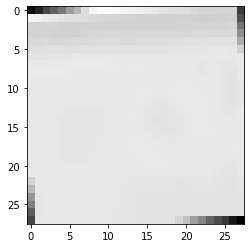

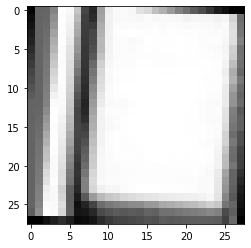

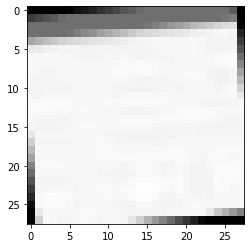

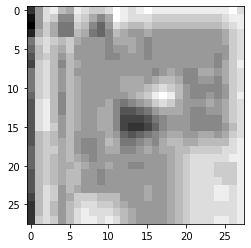

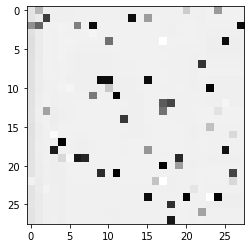

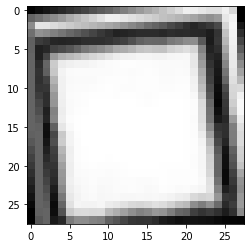

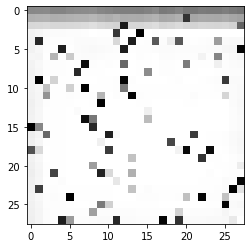

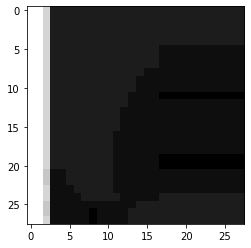

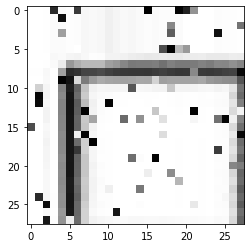

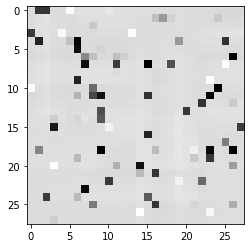

In [25]:
for k in seq_boxes(images=zero_boxes_to_add[:10]):
    plt.figure()
    plt.imshow(k, "gray")
    plt.plot()

In [26]:
row_i = np.random.choice(len(zero_boxes_to_add), size=zero_and_marked_boxes_number)

chosen_zero_boxes = np.array(zero_boxes_to_add)[row_i]
chosen_zero_boxes.shape

(200000, 28, 28)

In [0]:
chosen_zero_boxes = seq_boxes(images=chosen_zero_boxes)

In [28]:
chosen_zero_boxes.shape

(200000, 28, 28)

In [0]:
marked_boxes_to_add = []

for filename in os.listdir("zero_and_marks/marked_boxes_updated_train"):
    if (".jpg" in filename or ".png" in filename) and not (filename.startswith(".")):
        filepath = "zero_and_marks/marked_boxes_updated_train/{}".format(filename)
        im=Image.open(filepath)
        im=im.resize((28 ,28),Image.ANTIALIAS)
        im = np.array(im)
        if im.shape != (28, 28):
            im = np.min(im, axis=2)

        marked_boxes_to_add.append(im)
        

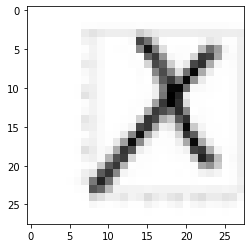

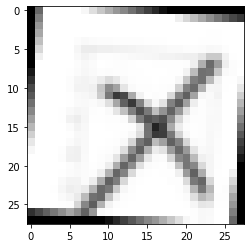

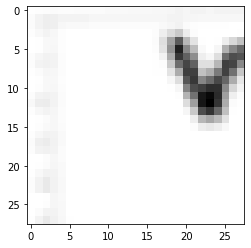

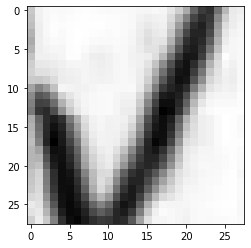

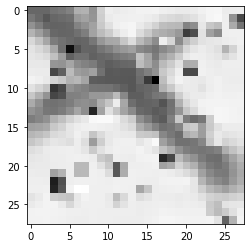

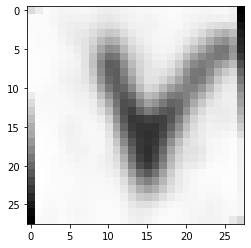

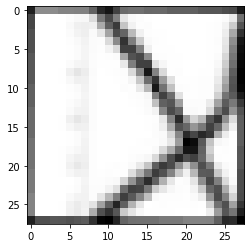

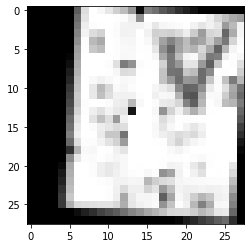

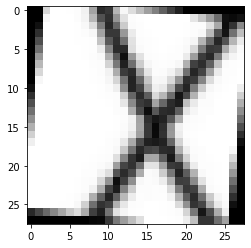

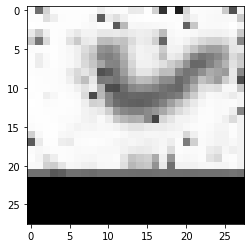

In [30]:
for k in seq_boxes(images=marked_boxes_to_add[:10]):
    plt.figure()
    plt.imshow(k, "gray")
    plt.plot()

In [31]:
row_i = np.random.choice(len(marked_boxes_to_add), size=zero_and_marked_boxes_number)

chosen_marked_boxes = np.array(marked_boxes_to_add)[row_i]
chosen_marked_boxes.shape

(200000, 28, 28)

In [0]:
chosen_marked_boxes = seq_boxes(images=chosen_marked_boxes)

In [0]:
y_zero_boxes = np.array([10] * zero_and_marked_boxes_number)
y_marked_boxes = np.array([11] * zero_and_marked_boxes_number)

Объединяем в единый датасет как квадратики, так и чиселки

In [0]:
X_train_choosen = np.concatenate([X_train_1_7, X_train_not_1_7, chosen_zero_boxes, chosen_marked_boxes])
y_train_choosen = np.concatenate([y_train_1_7, y_train_not_1_7, y_zero_boxes, y_marked_boxes])

In [0]:
X_train_choosen = X_train_choosen.reshape(X_train_choosen.shape[0],28,28, 1)
X_test = X_test.reshape(X_test.shape[0],28,28, 1)

In [0]:
y_train_choosen = to_categorical(y_train_choosen)
y_test = to_categorical(y_test)

In [37]:
y_test.shape

(20000, 10)

In [0]:
b = np.zeros((20000,10+2))
b[:,:-2] = y_test

In [0]:
checkpoint = ModelCheckpoint("best_great_model_sep_1_7.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [0]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model_json = model.to_json()
open("mnist_mega_model_4_sep_1_7.json", "w").write(model_json)
model.fit(X_train_choosen, y_train_choosen, validation_data=(X_test, b), 
          epochs=20,  shuffle=True, callbacks=[checkpoint], batch_size=100)
model.save_weights('mnist_mega_model_4_sep_1_7')


Train on 1400000 samples, validate on 20000 samples
Epoch 1/20
1400000/1400000 [==============================] - 623s 445us/step - loss: 0.3589 - accuracy: 0.8977 - val_loss: 0.3291 - val_accuracy: 0.9234

Epoch 00001: loss improved from inf to 0.35894, saving model to best_great_model_sep_1_7.hdf5
Epoch 2/20
1400000/1400000 [==============================] - 619s 442us/step - loss: 0.1233 - accuracy: 0.9681 - val_loss: 0.0385 - val_accuracy: 0.9916

Epoch 00002: loss improved from 0.35894 to 0.12328, saving model to best_great_model_sep_1_7.hdf5
Epoch 3/20
1400000/1400000 [==============================] - 629s 449us/step - loss: 0.0967 - accuracy: 0.9751 - val_loss: 0.0122 - val_accuracy: 0.9962

Epoch 00003: loss improved from 0.12328 to 0.09670, saving model to best_great_model_sep_1_7.hdf5
Epoch 4/20
1400000/1400000 [==============================] - 628s 449us/step - loss: 0.0833 - accuracy: 0.9788 - val_loss: 0.0117 - val_accuracy: 0.9969

Epoch 00004: loss improved from 0.0967

In [49]:
model_json = model.to_json()
open("mnist_mega_model_4_sep_1_7.json", "w").write(model_json)
model.fit(X_train_choosen, y_train_choosen, validation_data=(X_test, b), 
          epochs=1,  shuffle=True, callbacks=[checkpoint], batch_size=100)
model.save_weights('mnist_mega_model_4_sep_1_7_')


Train on 1400000 samples, validate on 20000 samples
Epoch 1/1
1400000/1400000 [==============================] - 617s 441us/step - loss: 0.0419 - accuracy: 0.9893 - val_loss: 0.0107 - val_accuracy: 0.9973

Epoch 00001: loss improved from 0.04276 to 0.04190, saving model to best_great_model_sep_1_7.hdf5


In [0]:
model.save_weights('best_great_model_sep_1_7.hdf5')

In [45]:
model_json = model.to_json()
open("mnist_mega_model_1.json", "w").write(model_json)

11779

In [0]:
def process_image_before_recognizing(filename):
    delta = 0
    separator = 120
    im = Image.open(filename)
    initial_image = Image.open(filename)
    enhancer = ImageEnhance.Contrast(im)

    factor = 10
    im = np.array(enhancer.enhance(factor))
    
    morph = im.copy()

    gray_image = np.min(im, axis=2)
    #plt.imshow(foo, "gray")

    result = ndimage.gaussian_filter(gray_image, 0)
    #result = ndimage.minimum_filter(result, size=3)

    #foo = Image.open("seven.png")
    #foo = foo.resize((28 +2 * delta,28 + 2 * delta), Image.NEAREST)
    #im = np.array(foo)
    #gray_image = np.min(im, axis=2)
    #gray_image = gray_image[: , : ]
    gray_image_for_prediction=result
    im_from_array = Image.fromarray(gray_image_for_prediction)
    im_from_array = im_from_array.resize((28 +2 * delta,28 + 2 * delta),Image.ANTIALIAS)
    #gray_image = (gray_image) * (20 / 255)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    gray_image_for_prediction[gray_image_for_prediction > separator] = 255
    return gray_image_for_prediction

In [0]:
def recognize_and_print_digit(filename):
    delta = 0
    separator = 120
    im = Image.open(filename)
    initial_image = Image.open(filename)
    enhancer = ImageEnhance.Contrast(im)

    factor = 10
    im = np.array(enhancer.enhance(factor))
    
    morph = im.copy()

    gray_image = np.min(im, axis=2)

    result = ndimage.gaussian_filter(gray_image, 0)

    gray_image_for_prediction=result
    im_from_array = Image.fromarray(gray_image_for_prediction)
    im_from_array = im_from_array.resize((28 +2 * delta,28 + 2 * delta),Image.ANTIALIAS)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    gray_image_for_prediction[gray_image_for_prediction > separator] = 255
    print(np.argmax(model.predict(gray_image_for_prediction.reshape(1, 28, 28, 1))),
         np.max(model.predict(gray_image_for_prediction.reshape(1, 28, 28, 1))))
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(gray_image_for_prediction, "gray")
    ax[1].imshow(initial_image)
    plt.show()

In [0]:
import os
for filename in os.listdir():
    if filename.endswith(".png") or filename.endswith(".jpg"):
        recognize_and_print_digit(filename)